# _Notebook Jupyter_ 8_prediçãoRisco

# Predição do Risco dada uma Importação

O objetivo agora é dada uma importação contendo **kit de transmissão de motocicletas** fazer a sua classificação e em seguida apresentar uma análise de risco visual baseada na estatística existente de outras importações.<br>
É importante salientar que esta análise não substitui a acurada análise a ser realizada por um Auditor Fiscal, tendo em vista que o resultado será uma lista de parâmetros objetivos que indicarão graus de observação para o gerenciamento de risco.
Desse modo, a entrada será o registro de importação contendo todos os campos. A função determinará a classificação e com base nos valores declarados de outras importações da mesma classificação, fará a comparação analítica com o valor da importação em análise.

## Importando bibliotecas

In [1]:
import pandas as pd, time
import pickle
# Vetorização
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Modelos
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn import metrics
# Divisor de Treino/Treste
from sklearn.model_selection import train_test_split
# Matplot
import matplotlib.pyplot as plt

In [2]:
# importa funções criadas no módulo 3_classificarAplicação.ipynb (criarModelo.py)
from funcoesTCC import *
# Funções: criaModelo, limpaDescricao, achaPalavraChave, pegaChave, acrescentaMarca, retentorAux
# Variávis: stopwords, palavrasChave, Marcas
# Datasets: dftemp (Aplicações)

In [3]:
# Data e hora da execução do script
print(f'Código executado em {time.strftime("%d/%m/%Y às %H:%M", time.localtime(time.time()))}')

Código executado em 12/01/2022 às 19:47


## Treinamento do Classificador Linear SVC

Pela velocidade, versatilidade, facilidade de uso e, obviamente, a acurácia, optou-se pelo modelo do classificador Linear SVC.

In [4]:
# Importa base de dados com os modelos já determinados para um dataframe
df = pd.read_excel(r'./bases/dataframe_modelos_classificado.xlsx')
# Criação da função CountVectorizer
cvt = CountVectorizer(strip_accents='ascii', lowercase=True)
X_cvt = cvt.fit_transform(df['Modelo'])
# Criação da função TfidfTransformer
tfi = TfidfTransformer(use_idf=True)
X_tfi = tfi.fit_transform(X_cvt)


# A entrada será a transformação de vetores com a normalização tf-idf
#entrada = X_tfi
# A saida será as aplicações
#saida = df['APLICACAO']
# Separando 1% dos dados para teste
#X_train, X_test, y_train, y_test = train_test_split(entrada, saida, test_size=0.01)


# Como o modelo já foi testado, utilizaremos todo a base como treinamento
X_train=X_tfi.toarray()
y_train=np.array(df['APLICACAO'])

# Criando modelo
clfsvc = LinearSVC()
# Treinamento do modelo
clfsvc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Importando a Tabela ABIMOTO

In [5]:
dfABIMOTO = pd.read_excel(r'./bases/dfABIMOTOv13.xlsx')

In [6]:
dfABIMOTO.sample()

,PARTES E PEÇAS,VMLE,RETENTOR
5,KIT TRANSMISSÃO 1045 FAZER 250 SEM RETENTOR,4.5,False


##### Função de classificação LinearSVC

In [7]:
def classificaAplicacaoSVC(modelo):
    novo_cvt = cvt.transform(pd.Series(modelo))
    novo_tfi = tfi.transform(novo_cvt)
    aplicacao = clfsvc.predict(novo_tfi)[0]
    return aplicacao

In [8]:
descricao = df.iloc[13454]['DESCRICAO DO PRODUTO'] 
# verifica a descrição do produto
descricao

'10540017 IN KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: NXR150BROS09 49D/17D/428UOX128L MARCA: SCUD'

In [9]:
classificaAplicacaoSVC(criaModelo(descricao))

'HONDA NXR 150 BROS BROZ'

#### Classificando a Tabela ABIMOTO

In [10]:
dfABIMOTO['APLICACAO']=dfABIMOTO['PARTES E PEÇAS'].apply(classificaAplicacaoSVC)

In [11]:
dfABIMOTO.sample()

,PARTES E PEÇAS,VMLE,RETENTOR,APLICACAO
8,KIT TRANSMISSÃO 1045 YBR-125 2000/2002 14D+428...,7.7,True,YAMAHA FACTOR YBR 125 YBR125


#### Função de busca do valor da Aplicação na Tabela ABIMOTO

In [12]:
def achaValorABIMOTO(aplicacao, retentor):
    dfABtemp=dfABIMOTO[dfABIMOTO['APLICACAO']==aplicacao]
    dfABtemp=dfABtemp[dfABtemp['RETENTOR']==retentor]
    if dfABtemp.shape[0]==0:
        return 0
    return min(dfABtemp['VMLE'])

##### Define linha exemplo (PODE APAGAR AO FINAL)

In [13]:
dfimp=df.sample(50)
dfimp.sample()

,PAIS DE ORIGEM,DESCRICAO DO PRODUTO,VALOR UN.PROD.DOLAR,DESCRICAO,Modelo,APLICACAO,RETENTOR
4944,"CHINA, REPUBLICA POP",10530027 IN KIT TRANSMISSÃO P/MOTOCICLETAS(COR...,4.119,ybr-125,YAMAHA 125 YBR,YAMAHA FACTOR YBR 125 YBR125,False


## Função de determinação do risco

Os valores _outliers_ foram removidos segundo o parâmetro de distância interquartílica, dado pela expressão da imagem abaixo:

Apesar da bibliografia indicar o uso de uma vez e meia o intervalo entre o primeiro e o terceiro quartil para definir os _outliers_, optou-se nesse trabalho, por uma questão de segurança, em utilizar o valor de três vezes.

In [14]:
def plotrisco(P, valor,valorABIMOTO=0):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    # cria o plot
    fig, ax = plt.subplots(figsize=(10, 1.25))
    # define os dados sequenciais, posição e cores
    ax.broken_barh([(0,P[0]),(P[0],P[1]), (P[1],P[11]), (P[11],P[3]), (P[3],P[4]), (P[4],P[5]),
                             (P[5],P[6]), (P[6],P[7]), (P[7],P[8]), (P[8],P[9]), (P[9],P[10])], 
                    [10, 9], 
                   facecolors=('#c10000', 'r', 'r','#fdff01', '#00fe32', '#02ff00', 
                               '#02ff00','#02ff00', '#00fe32','#00fe32', '#006dff'))
    # define limites dos eixos x e y
    ax.set_ylim(10,15)
    ax.set_xlim(P[0], P[10])
    # define os marcadores dos eixos
    ax.set_yticks([])
    ax.set_xticks([P[11],P[5],P[9]])
    ax.set_axisbelow(True)
    # define os textos
    #ax.text((P[0]+P[1])/2, 14, "P10%", fontsize=12, verticalalignment='center', horizontalalignment='center')
    ax.text(P[1], 15.5, "P10%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[1], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
 
    ax.text(P[11], 15.5, "P25%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[11], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(P[5], 15.5, "P50%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[5], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(P[12], 15.5, "P75%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[12], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(P[9], 15.5, "P90%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[9], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    ax.text(P[10], 15.5, "P100%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(P[10], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    # o valor (P[10]-P[0])/40 relativiza a escala na hora de mover algo no gráfico.
    undrelativa = (P[10]-P[0])/40
    ax.text(P[0]-1*undrelativa, 12.5, f"Min({P[0]})", fontsize=12, verticalalignment='center', horizontalalignment='center',rotation='vertical')
    ax.text((P[5]), 8, "Mediana", fontsize=12, verticalalignment='center', horizontalalignment='center')
    ax.text(P[10]+1*undrelativa, 12.5, f"Máx({P[10]})", fontsize=12, verticalalignment='center', horizontalalignment='center',rotation='vertical')
    # define alertas
    alerta=''
    # alerta quando valor fora dos limites máximo e mínimo
    if valor<P[0] or valor>P[10]:
        alerta+=f"ATENÇÃO: Valor declarado de USD{valor:.2f} fora dos limites do modelo (outlier)."
        alerta+='\n'
    if valorABIMOTO>valor:
        alerta+=f"ATENÇÃO: Valor declarado de USD{valor:.2f} menor que referência mínima ABIMOTO: USD{valorABIMOTO:.2f}."
    ax.text((P[10]+P[0])/2, 6, alerta, fontsize=16, color='r', verticalalignment='center', horizontalalignment='center')
    # define o título
    fig.suptitle('Previsão de Risco', fontsize=16, y=1.5, horizontalalignment='center')
    # cores do ponteiro
    cores=['#a20000','#ff6900', '#007d00', '#00007d'] # vermelho, amarelo, verde, azul
    # condições para determinar a cor do ponteiro
    if   valor>=P[9]: cor=cores[3]
    elif valor>=P[3]: cor=cores[2]
    elif valor>=P[11]: cor=cores[1]
    else:             cor=cores[0]
    # plota o ponteiro e o valor
    ax.scatter(x=valor, y=10.9, marker='v', c=cor, s=400)
    ax.text(valor, 12.2, valor, color='black', fontsize=14, verticalalignment='center', horizontalalignment='center')
    ax.vlines(x=P[5], ymin=10, ymax=15)
    # se existir valor na tabela ABIMOTO
    if valorABIMOTO>0:
        ax.scatter(x=valorABIMOTO, y=10.7, marker='v', c='black', s=200)
        if valorABIMOTO>valor:
            ax.text(valorABIMOTO+1*undrelativa, 10.6, f'{valorABIMOTO:.2f}(ABIMOTO)', color='black', fontsize=12, verticalalignment='center', horizontalalignment='left')
        else:
            ax.text(valorABIMOTO-1*undrelativa, 10.6, f'(ABIMOTO){valorABIMOTO:.2f}', color='black', fontsize=12, verticalalignment='center', horizontalalignment='right')
    # mostra o gráfico
    plt.show()

In [15]:
def riscoValor(dfimp):
    import matplotlib.pyplot as plt
    p=67 # repetições dos - nos prints
    # dfimp será uma série ou dataframe pandas contendo as importações a analisar
    # caso tenha mais de uma linha, será iterada sobre todas as linhas.
    if type(dfimp)==type(pd.Series([])):    tipo='s' # tipo series
    if type(dfimp)==type(pd.DataFrame([])): tipo='d' # tipo dataframe
    if not(tipo=='s' or tipo=='d'): # se o tipo não for séries ou dataframe
        raise TypeError('É preciso entrar com um dataframe ou uma Series do pandas.')
    if tipo=='d': # se for do tipo dataframe
        for i, linha in dfimp.iterrows(): # executa a função novamente para cada linha (series)
            riscoValor(linha) # reexecuta para cada linha se fornecido um dataframe
    elif tipo=='s': # se o tipo for uma series executa a rotina
        print('\x1b[1;31m'+'RELATÓRIO DE RISCO'+'\x1b[0m')
        #print(p*'-')
        print('\x1b[1;31m'+'\nDados da Declaração de Importação'+'\x1b[0m')
        descricao=dfimp['DESCRICAO DO PRODUTO']
        origem=dfimp['PAIS DE ORIGEM']
        retentor=retentorAux(dfimp['DESCRICAO DO PRODUTO'])
        retentortexto="com retentor" if retentor else "sem retentor"
        aplicacao=classificaAplicacaoSVC(criaModelo(descricao))
        valor=round(dfimp['VALOR UN.PROD.DOLAR'],2)
        valorABIMOTO=achaValorABIMOTO(aplicacao, retentor)
        print(f'Descrição: {descricao}\n'+
              f'Origem:    {origem}\n'+
              f'Retentor:  {retentortexto}\n'+
              f'Aplicação: {aplicacao}\n'+
              f'Valor DI:  USD {valor:.2f}')
        if valorABIMOTO>0: print(f'Tabela de Referência ABIMOTO\nValor:      USD {valorABIMOTO:.2f}\n')
        # filtra o df somente para os registros da aplicação classificda
        dfrisco=df[df['APLICACAO']==aplicacao] # filtra para a aplicação
        dfrisco=dfrisco[dfrisco['RETENTOR']==retentor] # filtra para a existência de retentor
        # remove os valores discrepantes dos dados
        # filtra somente valores de Q25-discrepancia*(Q75-Q25) a Q75+*discrepancia*(Q75-Q25)
        discrepancia=3 # valor padrão=1.5 
        P25=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],25)
        P75=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],75)
        min=P25-discrepancia*(P75-P25)
        max=P75+discrepancia*(P75-P25)
        filtro=[min<=dfrisco['VALOR UN.PROD.DOLAR']] and [dfrisco['VALOR UN.PROD.DOLAR']<=max]
        dfrisco=dfrisco[filtro[0]]
        # recálculo dos quartis 25 e 75 para df sem outliers
        P25=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],25)
        P75=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],75)
        # geração da lista com os quartis
        P=[round(np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],x),2) for x in range(0,110,10)]+[round(P25,2),round(P75,2)]
        estatisticas=dfrisco.describe()['VALOR UN.PROD.DOLAR']
        estatisticas.rename(index={'count':'qtd de registros:','mean':'média simples:','std':'desvio padrão:','min':'valor mínimo:','25%':'percentil 25%:','50%':'percentil 50%:','75%':'percentil 75%:','max':'valor máximo:'}, inplace=True)
        print('\x1b[1;31m'+f'Estatísticas:\n'+'\x1b[0m'+f'{estatisticas.to_string()}\n')
        # fazer um plot indicando a posição do valor em uma barra variando em vermelho-amarelo-verde-azul
        quartil={}
        for x in range(0,10): quartil[10+x*10] = P[x]
        quartil[25]=P25
        quartil[75]=P75
        perc=[f'{chave}={quartil[chave]:.2f}' for chave in sorted(quartil.keys())]
        print('\x1b[1;31m'+f'Percentis:\n'+'\x1b[0m'+f'  {str(perc[:6])[1:-1]}\n  {str(perc[6:])[1:-1]}')
        print('\x1b[1;31m'+f'\nHistograma por Decil:'+'\x1b[0m')
        plt.figure(figsize=(10,5),frameon=False)
        plt.hist(dfrisco['VALOR UN.PROD.DOLAR'],10,rwidth=0.9,range=(P[0],P[10]))
        plt.show()
        print('\x1b[1;31m'+f'Previsão de Risco:'+'\x1b[0m')
        plotrisco(P,valor,valorABIMOTO)
        print('\n\n')

RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 880481 - KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, UTILIZADO NAS MOTOS YES/INTRUDE125 C/RET1045 - MARCA KMC GOLD
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: SUZUKI YES EN 125
Valor DI:  USD 9.70
Estatísticas:
qtd de registros:    11.000000
média simples:        6.600852
desvio padrão:        2.673967
valor mínimo:         3.563200
percentil 25%:        3.871385
percentil 50%:        5.919200
percentil 75%:        9.403237
valor máximo:         9.696159

Percentis:
  '10=3.56', '20=3.64', '25=3.87', '30=3.66', '40=4.09', '50=5.43'
  '60=5.92', '70=8.27', '75=9.40', '80=9.39', '90=9.42', '100=9.54'

Histograma por Decil:


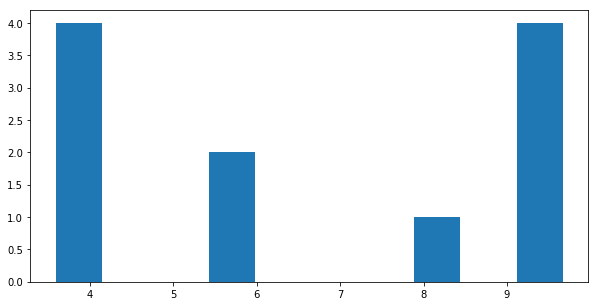

Previsão de Risco:


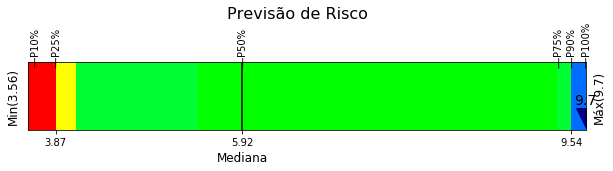

In [16]:
riscoValor(dfimp.iloc[0])

RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: COD.: 10397/I45 - KIT TRANSMISSAO PARA MOTOCICLETA - COMPOSTO DE CORRENTE, COROA E PINHAO - ACO 1045 CERTIFICADO TITAN 99 (43T/14T/428H X 116L). PRODUTO NOVO.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.90
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2928.000000
média simples:          4.032622
desvio padrão:          0.789523
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020618
percentil 75%:          4.500000
valor máximo:           7.107000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.24', '90=4.55', '100=4.70'

Histograma por Decil:


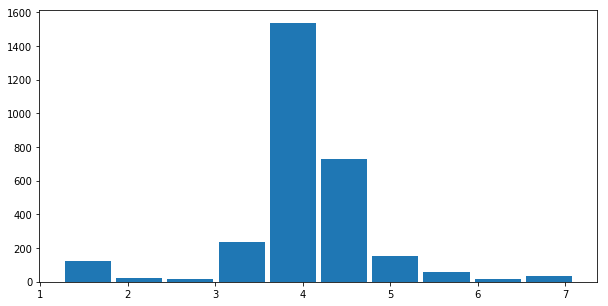

Previsão de Risco:


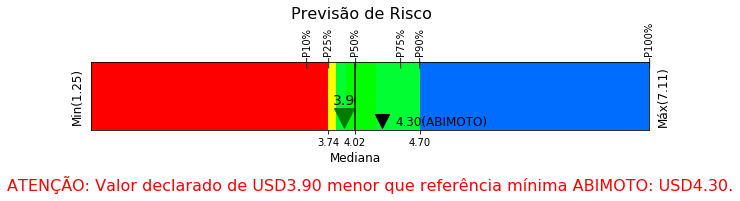




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM 1000233WR - KIT TRANSMISSÃO COMPOSTO DE COROA, CORRENTE E PINHÃO, PARA MOTOCICLETA MARCA WR COMPATÍVEL BROSS 125 54T-17T/428H 132L EM CX COM 10 UNIDADES
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 41.95
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.479750
desvio padrão:          1.863378
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.322000

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.69', '90=6.13', '100=8.58'

Histograma por Decil:


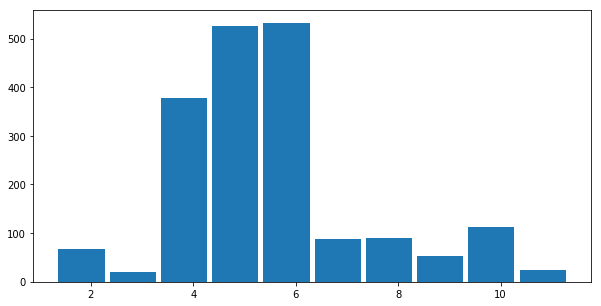

Previsão de Risco:


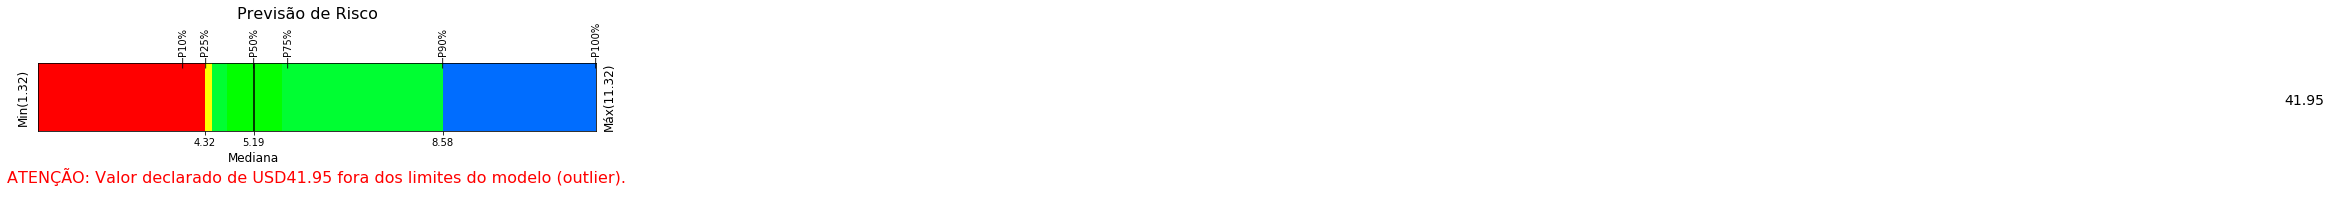




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO, MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS YBR 125 (03-08)/ YBR 125 FACTOR (03-16), COMPOSTO DE CORRENTE 428 X SM118 + COROA S41550 45Z + PINHAO 26571 14Z (CERTIFICADO NR. BR31512030) - ITEM: 71815
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 4.14
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1122.000000
média simples:          4.141602
desvio padrão:          0.887704
valor mínimo:           1.216719
percentil 25%:          3.659091
percentil 50%:          4.060000
percentil 75%:          4.670000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.66', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.67', '80=4.50', '90=4.81', '100=5.44'

Histograma por Decil:


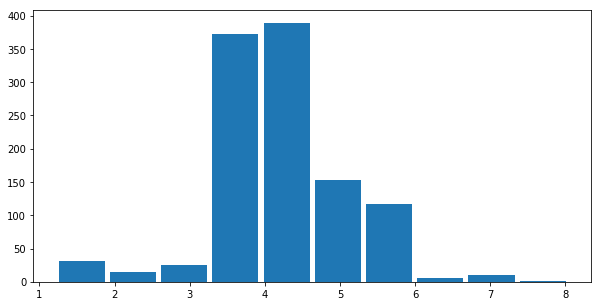

Previsão de Risco:


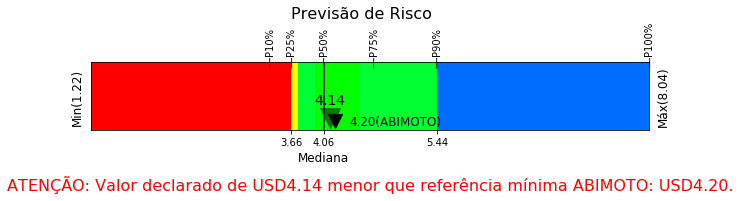




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CB TWISTER 250 (16-18), COMPOSTO DE CORRENTE 520 X M184 + COROA 40308 40Z + PINHAO 25138 13Z - ITEM: 91182
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 7.36
Tabela de Referência ABIMOTO
Valor:      USD 6.25

Estatísticas:
qtd de registros:    566.000000
média simples:         7.688954
desvio padrão:         2.992272
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.86', '25=5.81', '30=5.53', '40=5.96', '50=6.81'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.76', '100=12.70'

Histograma por Decil:


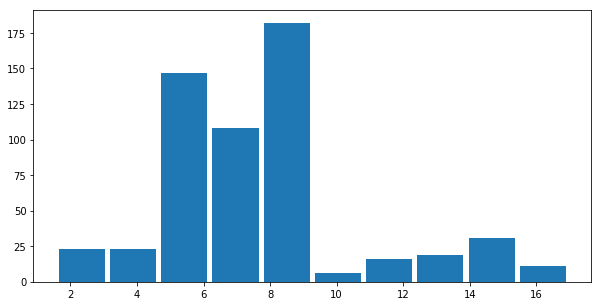

Previsão de Risco:


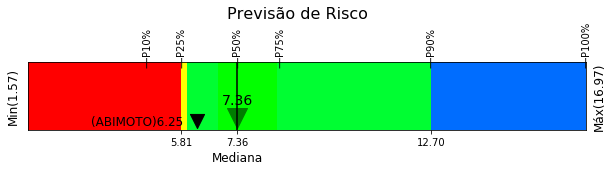




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 21991 - 71884 - KIT DE TRANSMISSAO PARA MOTOCICLETA MODELO: NXR 150 BROS (06-15) - CONTENDO: COROA 49Z - PINHAO 17Z - C/CORRENTE 428H X 130L - TITANIUM (1045)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 5.57
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.479750
desvio padrão:          1.863378
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.322000

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.69', '90=6.13', '100=8.58'

Histograma por Decil:


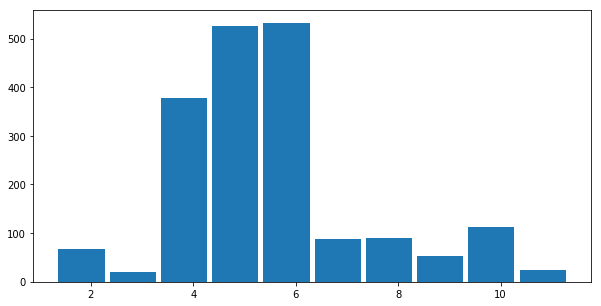

Previsão de Risco:


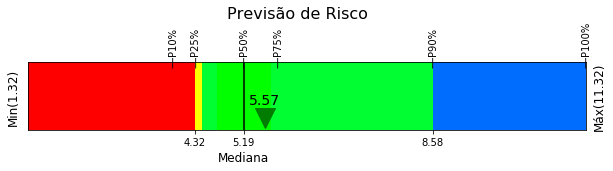




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10402/i45 - DESTAQUE NCM 002 KIT DE TRANSMISSAO COMPOSTO DE COROA, CORRENTE E PINHAO KIT DE TRANSMISSAO EM ACO 1045, COMPOSTO POR CORRENTE, COROA E PINHAO, APLICACAO TITAN 150 (43T/16T/428H x 118L) - , MARCA SIVERST
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.99
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2928.000000
média simples:          4.032622
desvio padrão:          0.789523
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020618
percentil 75%:          4.500000
valor máximo:           7.107000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.24', '90=4.55', '100=4.70'

Histograma por Decil:


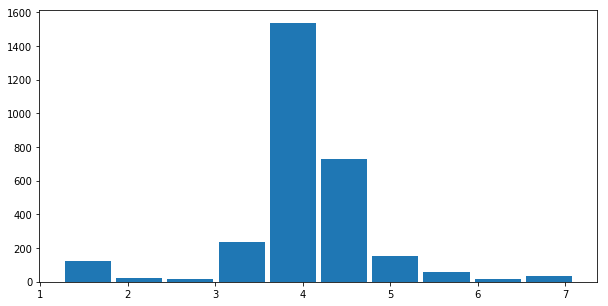

Previsão de Risco:


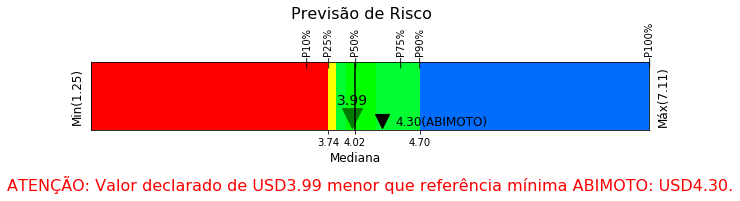




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 980738 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO PARA MOTOCICLETA YES/INTRUDER125 1045, MARCA VELTH.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUZUKI YES EN 125
Valor DI:  USD 3.41
Estatísticas:
qtd de registros:    207.000000
média simples:         4.088495
desvio padrão:         1.097315
valor mínimo:          1.256327
percentil 25%:         3.448000
percentil 50%:         3.845039
percentil 75%:         4.960000
valor máximo:          5.950000

Percentis:
  '10=1.26', '20=3.23', '25=3.45', '30=3.39', '40=3.49', '50=3.66'
  '60=3.85', '70=4.03', '75=4.96', '80=4.96', '90=5.38', '100=5.56'

Histograma por Decil:


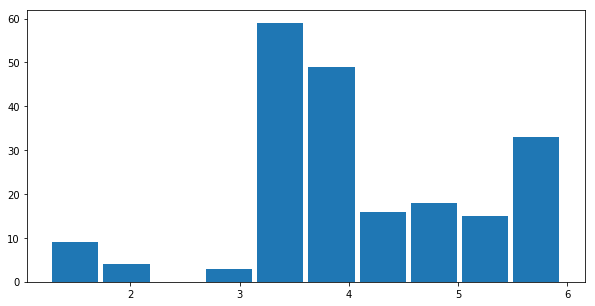

Previsão de Risco:


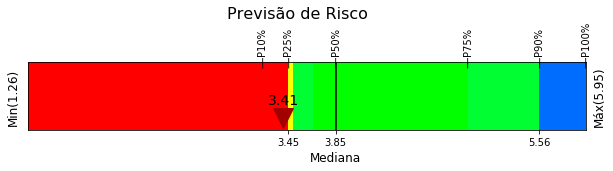




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P MOTOCICLETA MOD: XTZ 150 CROSSER (14-18) CONTENDO COROA 41Z;PINHAO 14Z;CORRENTE DE TRANSMISSAO 428H X 122L - TITANIUM (1045) 91161 91161
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 5.57
Estatísticas:
qtd de registros:    397.000000
média simples:         4.774163
desvio padrão:         1.611610
valor mínimo:          1.216000
percentil 25%:         3.667485
percentil 50%:         4.470000
percentil 75%:         5.578735
valor máximo:          9.150000

Percentis:
  '10=1.22', '20=3.45', '25=3.67', '30=3.60', '40=3.74', '50=3.99'
  '60=4.47', '70=5.15', '75=5.58', '80=5.48', '90=5.68', '100=7.09'

Histograma por Decil:


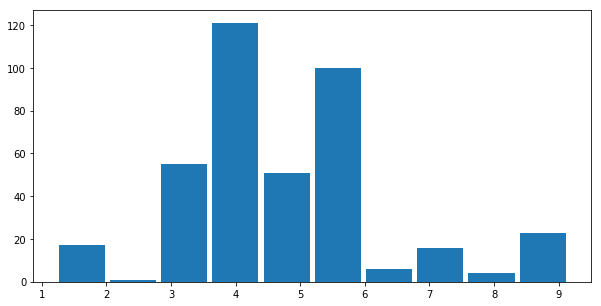

Previsão de Risco:


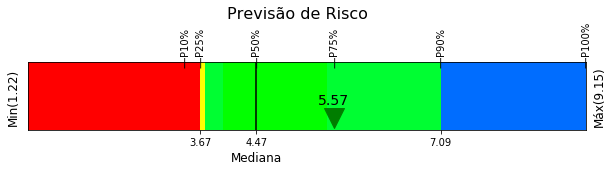




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10540017 IN KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: NXR150BROS09(17D/49D/128) MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 7.88
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.479750
desvio padrão:          1.863378
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.322000

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.69', '90=6.13', '100=8.58'

Histograma por Decil:


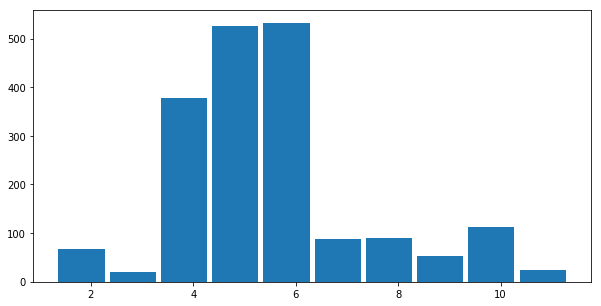

Previsão de Risco:


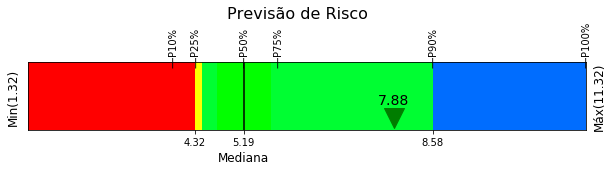




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 001-P21B-06500F - KIT DE TRANSMISSAO DO MOTOR DE MOTOCICLETA, COMPOSTO DE CORRENTE DE COMANDO, COROA E PINHAO, 1045 - 34D X 14D 428H X 104L STD POP 110 2016-2019 001-P21B-06500F
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA POP 100
Valor DI:  USD 3.71
Estatísticas:
qtd de registros:    746.000000
média simples:         3.596954
desvio padrão:         0.730702
valor mínimo:          1.083128
percentil 25%:         3.213462
percentil 50%:         3.594000
percentil 75%:         4.090000
valor máximo:          5.000000

Percentis:
  '10=1.08', '20=2.95', '25=3.21', '30=3.09', '40=3.29', '50=3.46'
  '60=3.59', '70=3.80', '75=4.09', '80=4.09', '90=4.19', '100=4.42'

Histograma por Decil:


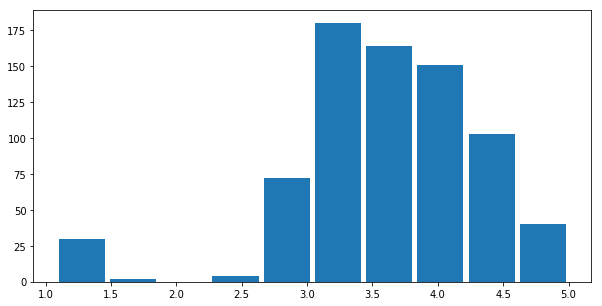

Previsão de Risco:


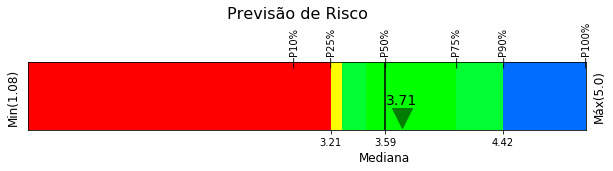




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P/ MOTOCICLETA MOD: C 100 BIZ (98-05) / C 100 BIZ + (02-05) CONTENDO COROA 35Z;PINHAO 15Z;CORRENTE DE TRANSMISSAO 428H X 108L - TITANIUM (1045) 71782 71782
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 4.19
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1385.000000
média simples:          3.646748
desvio padrão:          0.798591
valor mínimo:           1.051026
percentil 25%:          3.270000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.05', '20=3.00', '25=3.27', '30=3.21', '40=3.33', '50=3.55'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


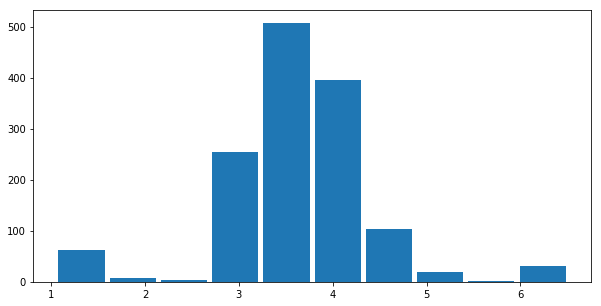

Previsão de Risco:


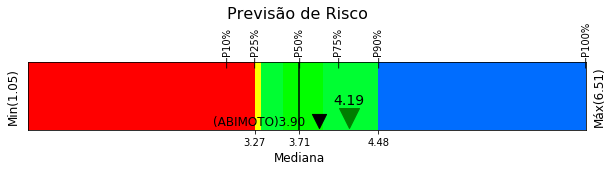




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 22305 - 91232 - KIT DE TRANSMISSAO PARA MOTOCICLETA MODELO C 100 DREAM CONTENDO: COROA 36Z - PINHAO 14Z - C/CORRENTE 428H X 98L TITANIUM (1045)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA DREAM
Valor DI:  USD 4.19
Estatísticas:
qtd de registros:    82.000000
média simples:       13.166888
desvio padrão:       13.582114
valor mínimo:         2.867400
percentil 25%:        4.190000
percentil 50%:        4.937750
percentil 75%:       28.674000
valor máximo:        39.023256

Percentis:
  '10=2.87', '20=3.10', '25=4.19', '30=3.43', '40=4.19', '50=4.32'
  '60=4.94', '70=5.07', '75=28.67', '80=27.56', '90=28.67', '100=35.62'

Histograma por Decil:


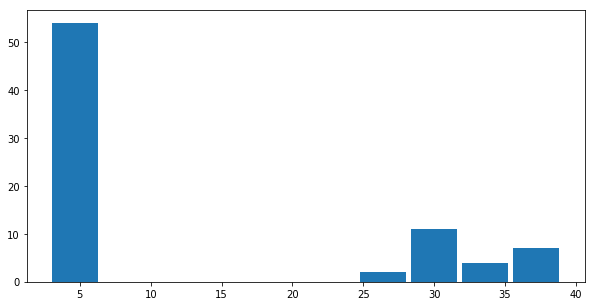

Previsão de Risco:


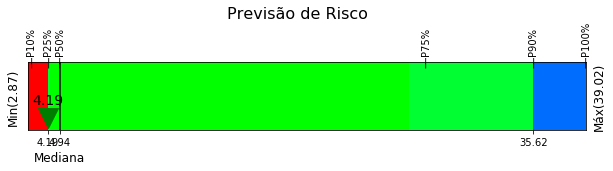




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E CICLOMOTORES, SENDO, KIT DE TRANSMISSÃO TITANIUM ( 1045) PARA YS 250 FAZER ( 06-17 ), COMPOSTO DE CORRENTE 428H X 132L, COROA 45Z, PINHÃO 15Z - ITEM 71879
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FAZER YS250 250
Valor DI:  USD 6.12
Tabela de Referência ABIMOTO
Valor:      USD 4.50

Estatísticas:
qtd de registros:    466.000000
média simples:         5.571051
desvio padrão:         1.735652
valor mínimo:          1.467516
percentil 25%:         4.210000
percentil 50%:         5.372500
percentil 75%:         6.760000
valor máximo:         11.358313

Percentis:
  '10=1.47', '20=3.82', '25=4.21', '30=4.10', '40=4.35', '50=4.61'
  '60=5.37', '70=6.31', '75=6.76', '80=6.73', '90=6.89', '100=7.76'

Histograma por Decil:


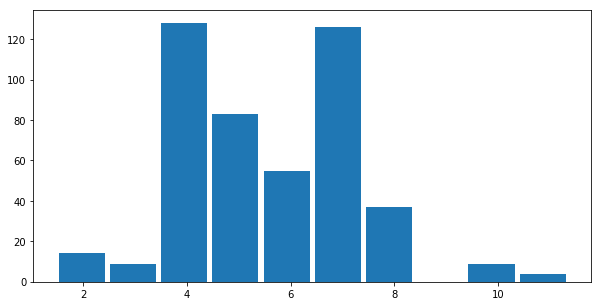

Previsão de Risco:


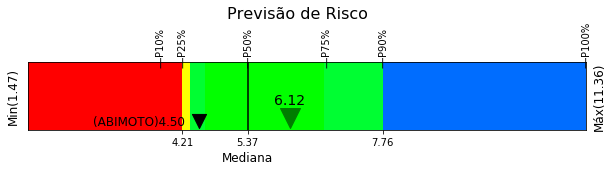




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P MOTOCICLETA MOD.: TITAN 150 (04-15); CONTENDO COROA 43Z ; PINHAO 16Z E CORRENTE DE TRANSMISSAO 428HO X 118L MARCA: EVOL 358553 358553
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 5.73
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2928.000000
média simples:          4.032622
desvio padrão:          0.789523
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020618
percentil 75%:          4.500000
valor máximo:           7.107000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.24', '90=4.55', '100=4.70'

Histograma por Decil:


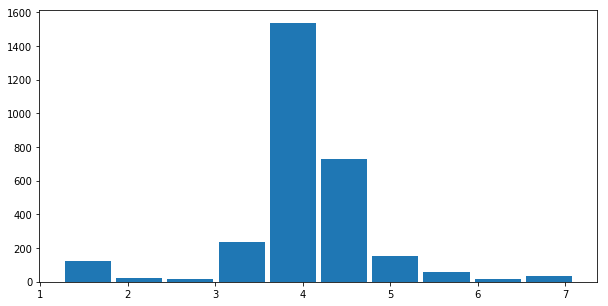

Previsão de Risco:


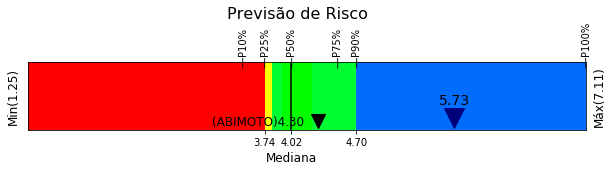




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 22302 - 71738 - KIT DE TRANSMISSAO PARA MOTOCICLETA MODELO CBX 200 / XR 200 CONTENDO: COROA 43Z - PINHAO 13Z (94-03) - C/CORRENTE 520H X 108L TITANIUM (1045)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA XR
Valor DI:  USD 8.38
Estatísticas:
qtd de registros:    64.000000
média simples:        7.206114
desvio padrão:        1.846087
valor mínimo:         2.300000
percentil 25%:        5.933874
percentil 50%:        7.148491
percentil 75%:        8.380000
valor máximo:        12.130000

Percentis:
  '10=2.30', '20=5.26', '25=5.93', '30=5.53', '40=6.31', '50=6.38'
  '60=7.15', '70=8.10', '75=8.38', '80=8.27', '90=8.38', '100=9.03'

Histograma por Decil:


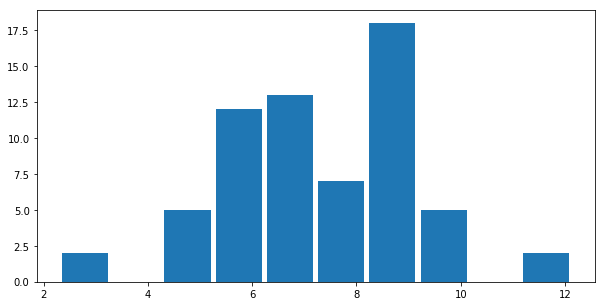

Previsão de Risco:


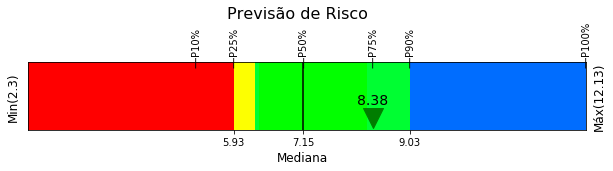




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 880354 - KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, UTILIZADO NAS MOTOS CRYPTON 115 11 - MARCA ALLEN
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA CRYPTON T115 115 100 110
Valor DI:  USD 2.99
Estatísticas:
qtd de registros:    260.000000
média simples:         3.989243
desvio padrão:         1.097880
valor mínimo:          1.214226
percentil 25%:         3.282539
percentil 50%:         3.571000
percentil 75%:         5.191200
valor máximo:          5.940000

Percentis:
  '10=1.21', '20=3.08', '25=3.28', '30=3.21', '40=3.34', '50=3.46'
  '60=3.57', '70=3.75', '75=5.19', '80=5.19', '90=5.24', '100=5.36'

Histograma por Decil:


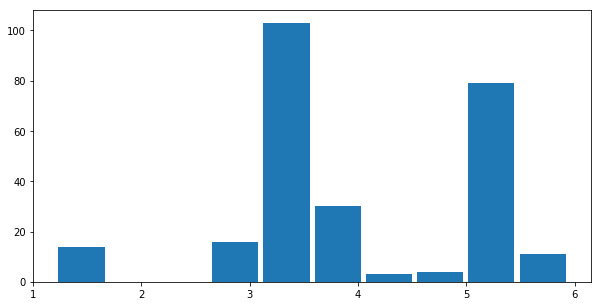

Previsão de Risco:


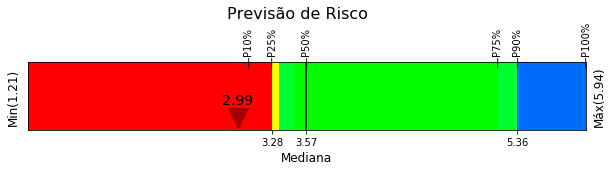




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO EM ACO 1045, COMPOSTO POR CORRENTE, COROA E PINHAO, APLICACAO BIZ 125 (34T/14T/428H X 106L) - MARCA SIVERST - 10403/I45 - PARA MOTOCICLETAS
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.31
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1385.000000
média simples:          3.646748
desvio padrão:          0.798591
valor mínimo:           1.051026
percentil 25%:          3.270000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.05', '20=3.00', '25=3.27', '30=3.21', '40=3.33', '50=3.55'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


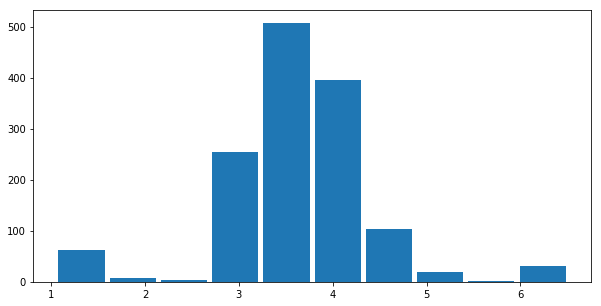

Previsão de Risco:


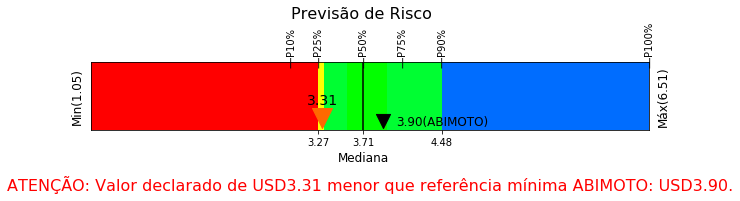




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P/ MOTOCICLETA MOD: C 100 BIZ (98-05) / C 100 BIZ + (02-05) CONTENDO COROA 35Z;PINHAO 15Z;CORRENTE DE TRANSMISSAO 428H X 108L - TITANIUM (1045) 71782 71782
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 4.19
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1385.000000
média simples:          3.646748
desvio padrão:          0.798591
valor mínimo:           1.051026
percentil 25%:          3.270000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.05', '20=3.00', '25=3.27', '30=3.21', '40=3.33', '50=3.55'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


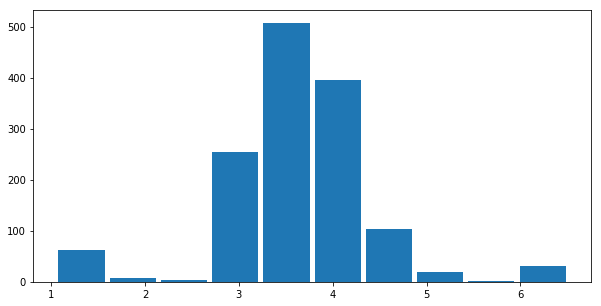

Previsão de Risco:


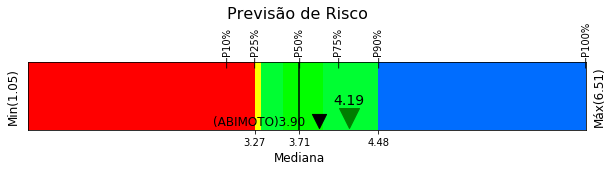




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO (1045) COMPOSTO DE CORRENTE, COROA E PINHAO COMPATIVEL COM MOTOCICLETA(S) MODELO(S): CG 125 TITAN 00 KS / ES / CARGO 2000 - 2008 - (44D x 14D - 428H x 116L STD). CODIGO: 001-P21B-03600.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.79
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2928.000000
média simples:          4.032622
desvio padrão:          0.789523
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020618
percentil 75%:          4.500000
valor máximo:           7.107000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.24', '90=4.55', '100=4.70'

Histograma por Decil:


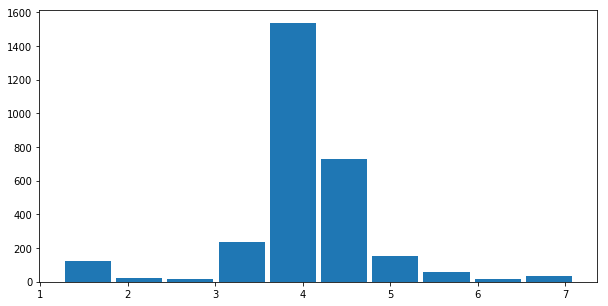

Previsão de Risco:


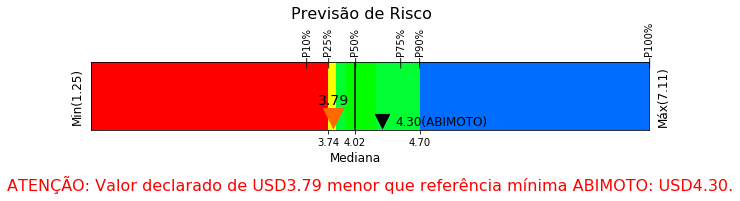




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO, MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 CARGO (09-13)/ CG 125 FAN (09-13), COMPOSTO DE CORRENTE 428 X SM117 + COROA S40230 43Z + PINHAO 25104 14Z (CERTIFICADO NR. BR31512030) - ITEM: 91048
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.05
Estatísticas:
qtd de registros:    1087.000000
média simples:          4.030933
desvio padrão:          0.660613
valor mínimo:           1.413541
percentil 25%:          3.800000
percentil 50%:          4.000000
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.55', '25=3.80', '30=3.70', '40=3.89', '50=3.97'
  '60=4.00', '70=4.10', '75=4.50', '80=4.28', '90=4.53', '100=4.70'

Histograma por Decil:


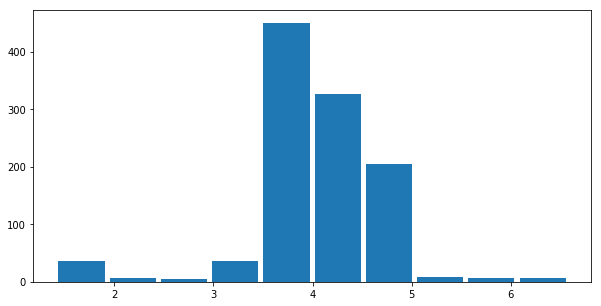

Previsão de Risco:


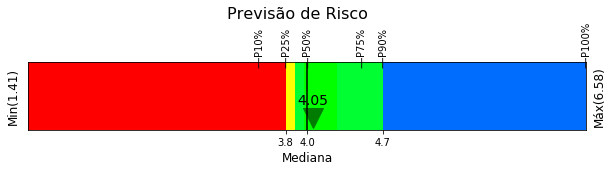




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P/ MOTOCICLETA MOD: XR 250 TORNADO CONTENDO COROA 38Z;PINHAO 13Z;CORRENTE DE TRANSMISSAO 520H X 104L - TITANIUM (1045) 71758 71758
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TORNADO XR 250
Valor DI:  USD 7.77
Estatísticas:
qtd de registros:    258.000000
média simples:         6.673494
desvio padrão:         2.506848
valor mínimo:          1.670000
percentil 25%:         5.050000
percentil 50%:         6.728654
percentil 75%:         7.772000
valor máximo:         16.096330

Percentis:
  '10=1.67', '20=4.11', '25=5.05', '30=4.90', '40=5.36', '50=5.71'
  '60=6.73', '70=7.02', '75=7.77', '80=7.53', '90=8.07', '100=8.98'

Histograma por Decil:


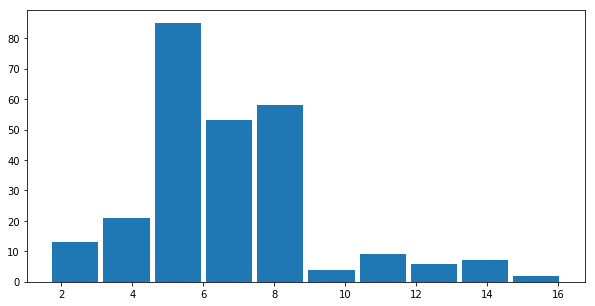

Previsão de Risco:


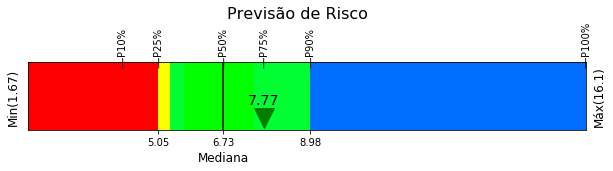




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10530027 IN KIT TRANSMISSÃO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: YBR-125 2003/08 14D/45D 428HX118L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 4.12
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1122.000000
média simples:          4.141602
desvio padrão:          0.887704
valor mínimo:           1.216719
percentil 25%:          3.659091
percentil 50%:          4.060000
percentil 75%:          4.670000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.66', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.67', '80=4.50', '90=4.81', '100=5.44'

Histograma por Decil:


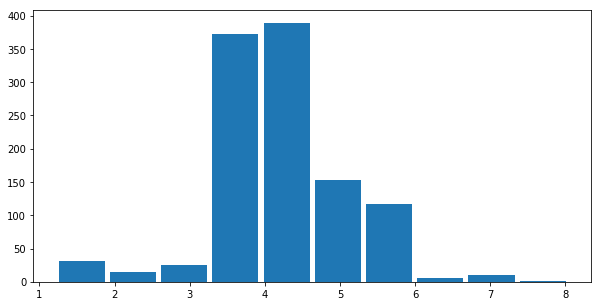

Previsão de Risco:


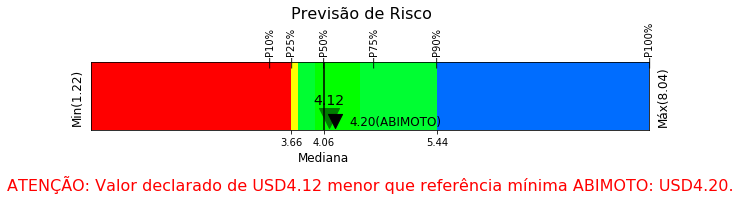




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E CICLOMOTORES SENDO, KIT DE TRANSMISSÃO TITANIUM ( 1045 ) PARA NXR 150 BROS ESD ( 03-05 ) COMPOSTO DE CORRENTE C/ 428H X 130L, COROA 50Z , PINHÃO 17Z - ITEM 71848.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 5.68
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.479750
desvio padrão:          1.863378
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.322000

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.69', '90=6.13', '100=8.58'

Histograma por Decil:


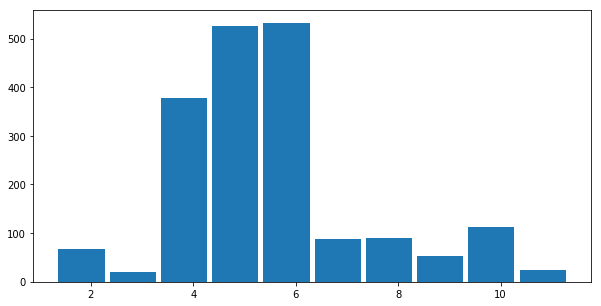

Previsão de Risco:


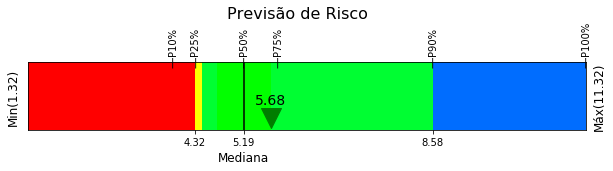




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO EM ACO 1045, PARA USO EM MOTOCICLETA, COMPOSTO POR CORRENTE, COROA E PINHAO, MARCA DURE, NXR 125 BROS (54T/17T/428H x 132L)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 4.72
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.479750
desvio padrão:          1.863378
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.322000

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.69', '90=6.13', '100=8.58'

Histograma por Decil:


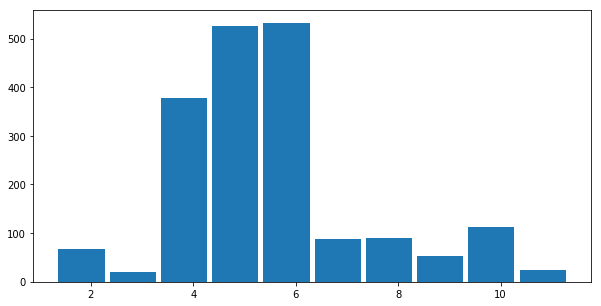

Previsão de Risco:


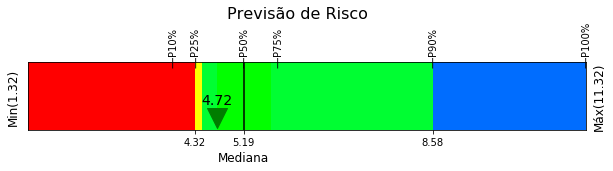




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE, COROA E PINHAO (EM AÇO 1045) COMPATIVEL COM MOTOCICLETA(S) MODELO(S): CG 125 TITAN 00 KS/ES/CARGO 2000-2008 (44Dx14D 428Hx116L). CÓDIGO: 001-P21B-03600.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.76
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2928.000000
média simples:          4.032622
desvio padrão:          0.789523
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020618
percentil 75%:          4.500000
valor máximo:           7.107000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.24', '90=4.55', '100=4.70'

Histograma por Decil:


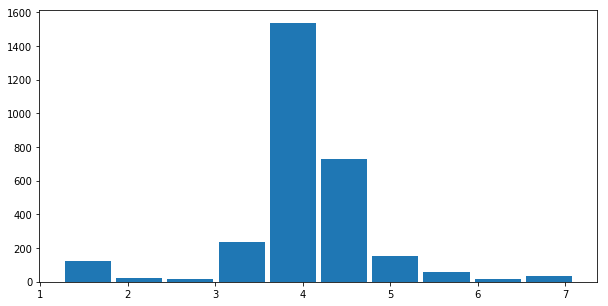

Previsão de Risco:


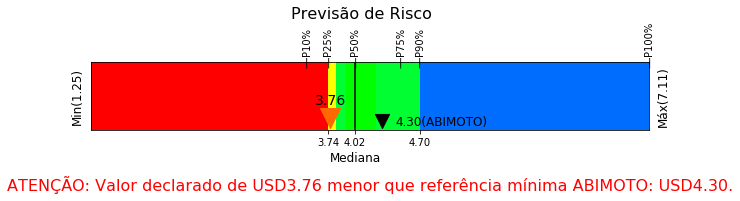




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 5008.809.212 - "KIT TRANSMISSAO UNIFORT (COROA, CORRENTE E PINHAO) CORRENTE 428X130 SEM RETENTOR, COROA 50 DENTES, PINHAO 17 DENTES MARCA: Unifort. APLICACAO: NXR 150 BROS 05>08"
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 4.50
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.479750
desvio padrão:          1.863378
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.322000

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.69', '90=6.13', '100=8.58'

Histograma por Decil:


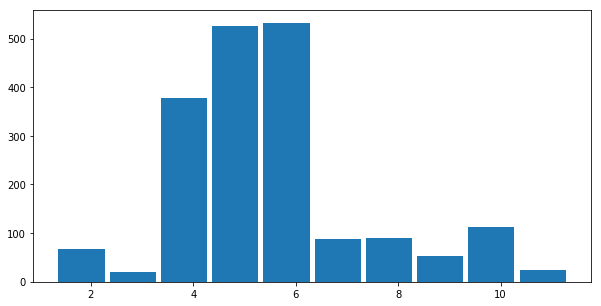

Previsão de Risco:


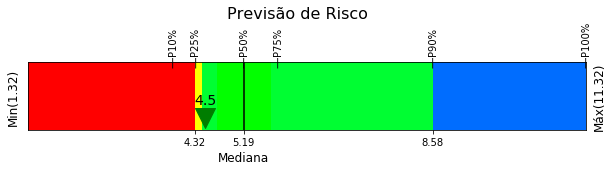




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 881746 - SEMI-KIT DE TRANSMISSAO COMPOSTO DE COROA E PINHAO SEM CORRENTE UTILIZADO NAS MOTOS CRYPTON 115 11 - DENTES: 41/15 - MARCA: ALLEN
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA CRYPTON T115 115 100 110
Valor DI:  USD 1.46
Estatísticas:
qtd de registros:    260.000000
média simples:         3.989243
desvio padrão:         1.097880
valor mínimo:          1.214226
percentil 25%:         3.282539
percentil 50%:         3.571000
percentil 75%:         5.191200
valor máximo:          5.940000

Percentis:
  '10=1.21', '20=3.08', '25=3.28', '30=3.21', '40=3.34', '50=3.46'
  '60=3.57', '70=3.75', '75=5.19', '80=5.19', '90=5.24', '100=5.36'

Histograma por Decil:


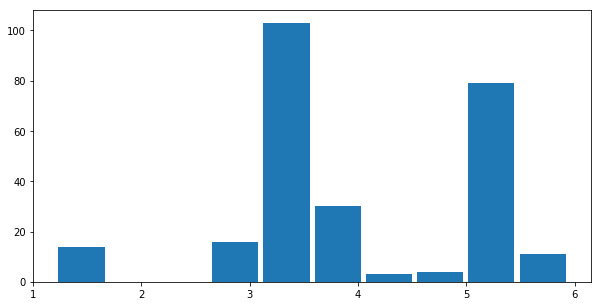

Previsão de Risco:


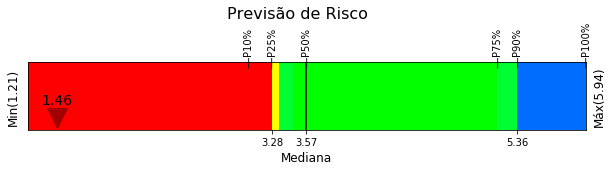




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: - KIT DE TRANSMISSÃO PARA MOTOCICLETA, COMPOSTO POR CORRENTE, COROA E PINHÃO - 1045 - 34D x 14D 428H x 104L STD, MODELO: POP 110 2016-2019. REF.: 001-P21B-06500
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA POP 100
Valor DI:  USD 3.38
Estatísticas:
qtd de registros:    746.000000
média simples:         3.596954
desvio padrão:         0.730702
valor mínimo:          1.083128
percentil 25%:         3.213462
percentil 50%:         3.594000
percentil 75%:         4.090000
valor máximo:          5.000000

Percentis:
  '10=1.08', '20=2.95', '25=3.21', '30=3.09', '40=3.29', '50=3.46'
  '60=3.59', '70=3.80', '75=4.09', '80=4.09', '90=4.19', '100=4.42'

Histograma por Decil:


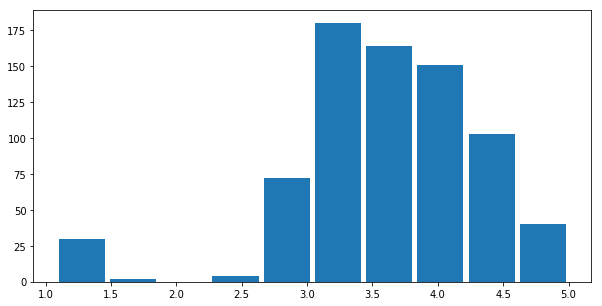

Previsão de Risco:


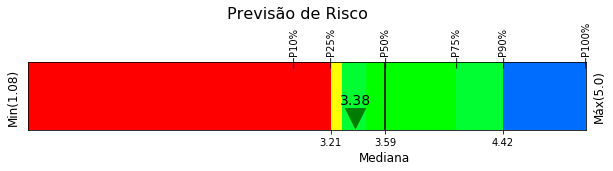




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM 18576 - KIT TRANSMISSÃO PARA MOTOCICLETA CONTENDO COROA, CORRENTE E PINHÃO MARCA BRAVO RACING COMPATÍVEL XTZ 150 CROSSER 2014 41T-14T 122L 428H, EM CX COM 10 UNIDADES
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 39.80
Estatísticas:
qtd de registros:    397.000000
média simples:         4.774163
desvio padrão:         1.611610
valor mínimo:          1.216000
percentil 25%:         3.667485
percentil 50%:         4.470000
percentil 75%:         5.578735
valor máximo:          9.150000

Percentis:
  '10=1.22', '20=3.45', '25=3.67', '30=3.60', '40=3.74', '50=3.99'
  '60=4.47', '70=5.15', '75=5.58', '80=5.48', '90=5.68', '100=7.09'

Histograma por Decil:


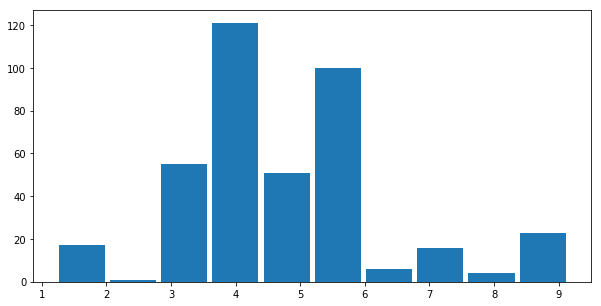

Previsão de Risco:


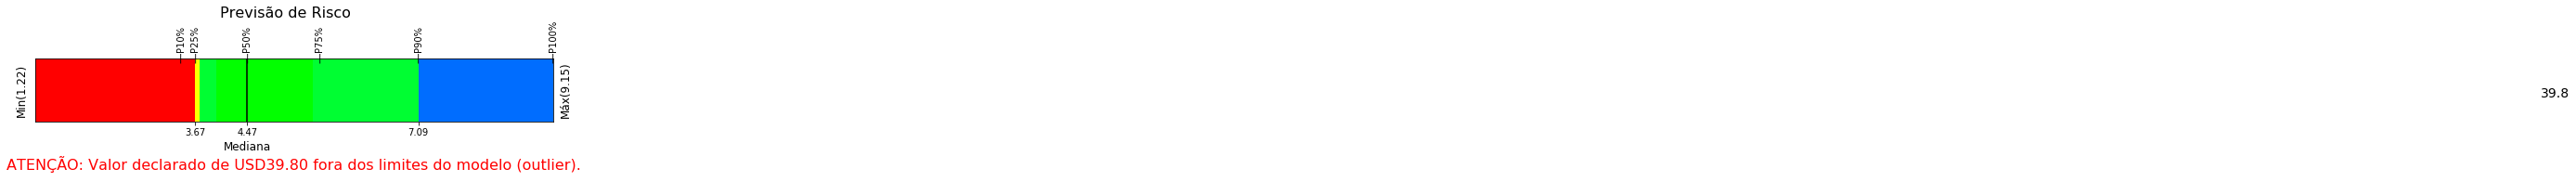




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TOP (1045) PARA MOTOCICLETAS NINJA 250R (88-07), COMPOSTO DE CORRENTE 520 X M362 + COROA 44088 45Z + PINHAO 29017 14Z (CERTIFICADO NR. BR31512031) - ITEM: 91124
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: KAHENA TOP
Valor DI:  USD 16.04
Estatísticas:
qtd de registros:    190.000000
média simples:         9.859819
desvio padrão:         3.272701
valor mínimo:          3.041700
percentil 25%:         8.150000
percentil 50%:         9.802897
percentil 75%:        10.520000
valor máximo:         16.201700

Percentis:
  '10=3.04', '20=6.90', '25=8.15', '30=7.04', '40=8.47', '50=8.60'
  '60=9.80', '70=10.06', '75=10.52', '80=10.34', '90=11.68', '100=15.69'

Histograma por Decil:


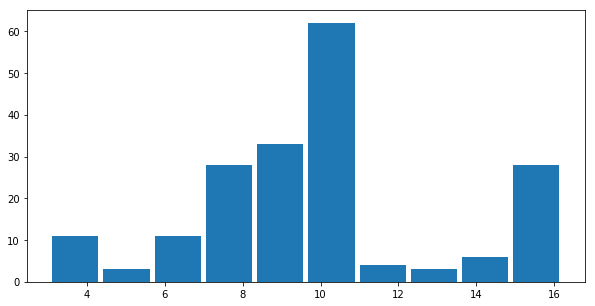

Previsão de Risco:


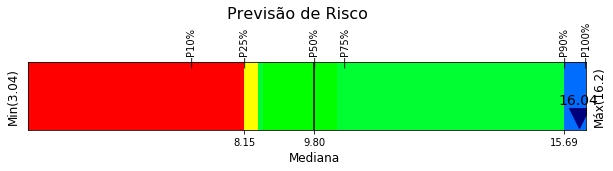




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: item .31;Partes e peças para Motocicletas,Destaque 002-kit de Transmissão composto de corrente,coroa e pinhão;Tipo/modelo:Kit transmission 33D x 14D 428H x 106L 1045 STD/BIZ 110 2016...;Nas Qdes:150unidades;Ref.:001-P21B-06600.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.41
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1385.000000
média simples:          3.646748
desvio padrão:          0.798591
valor mínimo:           1.051026
percentil 25%:          3.270000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.05', '20=3.00', '25=3.27', '30=3.21', '40=3.33', '50=3.55'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


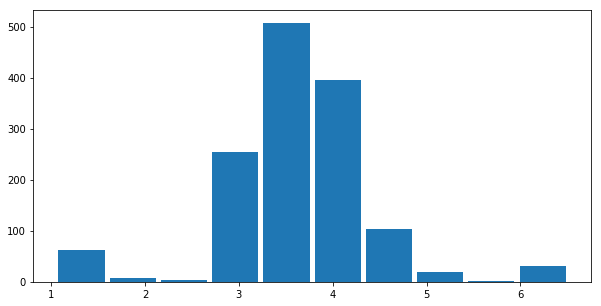

Previsão de Risco:


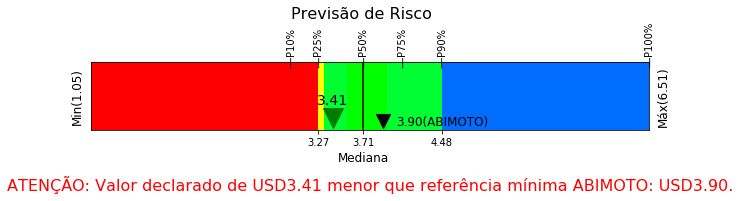




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: "CÓDIGO: 5008.809.017 | KIT TRANSMISSÃO UNIFORT (CORRENTE, COROA E PINHÃO) CORRENTE 428X116 SEM RETENTOR COROA 39 DENTES PINHÃO 15 DENTES MARCA: Unifort APLICAÇÃO: SPEED 150 MATERIAL DA COROA - AÇOMATERIAL DO PINHÃO - AÇO QUANTIDADE DE LIGAÇÕES DA CO
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: DAFRA SPEED
Valor DI:  USD 3.60
Estatísticas:
qtd de registros:    41.000000
média simples:        4.405681
desvio padrão:        1.276121
valor mínimo:         1.420000
percentil 25%:        3.559000
percentil 50%:        3.960000
percentil 75%:        5.314200
valor máximo:         5.980000

Percentis:
  '10=1.42', '20=3.18', '25=3.56', '30=3.31', '40=3.59', '50=3.67'
  '60=3.96', '70=5.15', '75=5.31', '80=5.31', '90=5.86', '100=5.98'

Histograma por Decil:


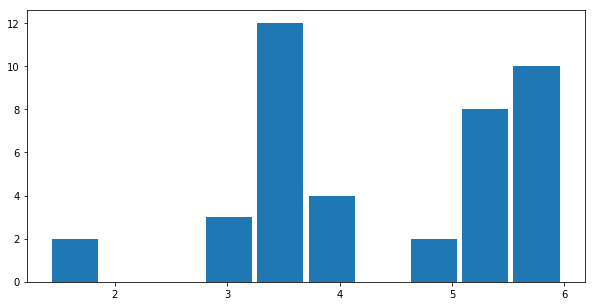

Previsão de Risco:


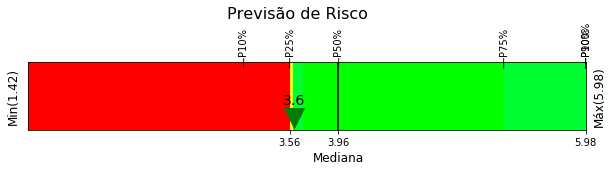




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 5008.809.210 - "KIT TRANSMISSAO UNIFORT (COROA, CORRENTE E PINHAO) CORRENTE 520X106 SEM RETENTOR, COROA 37 DENTES, PINHAO 13 DENTES MARCA: Unifort. APLICACAO: CBX 250 TWISTER 01>09"
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 7.00
Tabela de Referência ABIMOTO
Valor:      USD 6.25

Estatísticas:
qtd de registros:    566.000000
média simples:         7.688954
desvio padrão:         2.992272
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.86', '25=5.81', '30=5.53', '40=5.96', '50=6.81'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.76', '100=12.70'

Histograma por Decil:


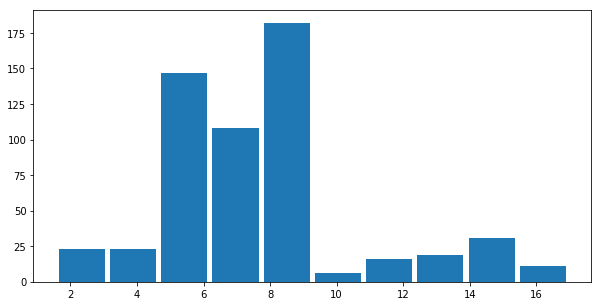

Previsão de Risco:


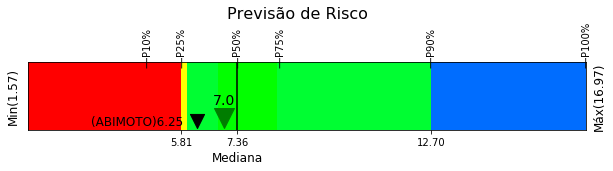




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 CARGO (09-13)/ CG 125 FAN (09-13), COMPOSTO DE CORRENTE 428 X SM117 + COROA S40230 43Z + PINHAO 25104 14Z - ITEM: 91048
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.53
Estatísticas:
qtd de registros:    1087.000000
média simples:          4.030933
desvio padrão:          0.660613
valor mínimo:           1.413541
percentil 25%:          3.800000
percentil 50%:          4.000000
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.55', '25=3.80', '30=3.70', '40=3.89', '50=3.97'
  '60=4.00', '70=4.10', '75=4.50', '80=4.28', '90=4.53', '100=4.70'

Histograma por Decil:


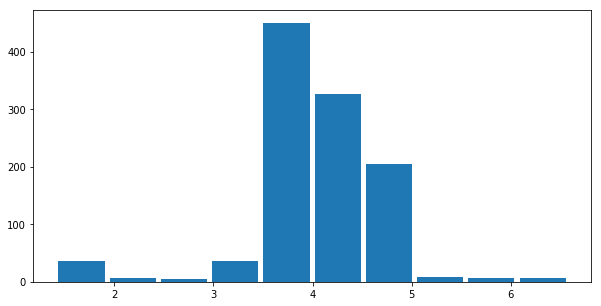

Previsão de Risco:


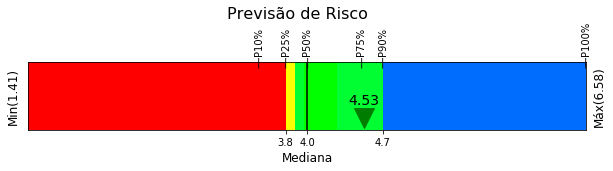




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, MODELO: KIT NXR BROS 150 49X17 428HX128L.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 4.70
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.479750
desvio padrão:          1.863378
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.322000

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.69', '90=6.13', '100=8.58'

Histograma por Decil:


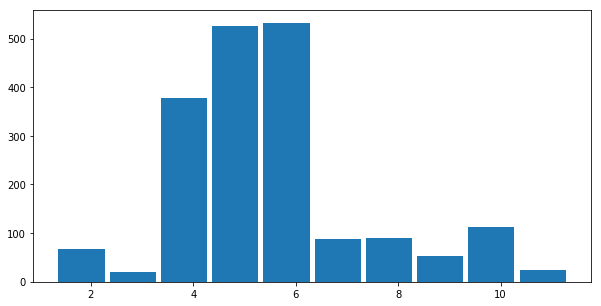

Previsão de Risco:


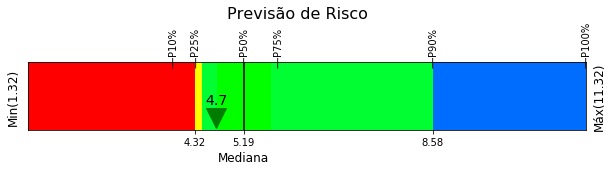




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 71899 - KIT DE TRANSMISSÃO PARA MOTOCICLETAS (CORRENTE, COROA e PINHÃO), MARCA: RIFFEL. SENDO: POP 100 (07-15) 35Z X 14Z WITH CHAIN 428H X 106L - TITANIUM (1045)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA POP 100
Valor DI:  USD 4.27
Estatísticas:
qtd de registros:    746.000000
média simples:         3.596954
desvio padrão:         0.730702
valor mínimo:          1.083128
percentil 25%:         3.213462
percentil 50%:         3.594000
percentil 75%:         4.090000
valor máximo:          5.000000

Percentis:
  '10=1.08', '20=2.95', '25=3.21', '30=3.09', '40=3.29', '50=3.46'
  '60=3.59', '70=3.80', '75=4.09', '80=4.09', '90=4.19', '100=4.42'

Histograma por Decil:


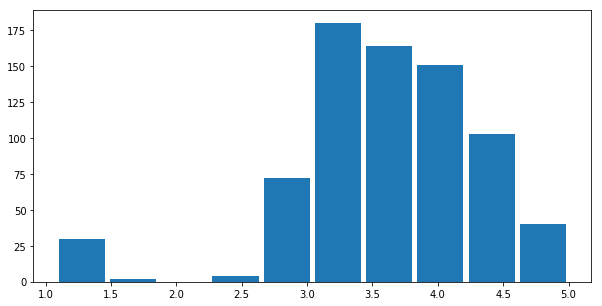

Previsão de Risco:


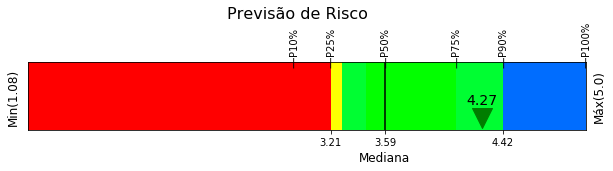




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: - KIT TRANSMISSAO TITANIUM PARA MOTOCICLETAS MODELO XTZ 150 CROSSER (14-18) 41Z X 14Z WITH CHAIN 428H X 122L, COMPOSTO POR CORRENTE, COROA E PINHÃO. CORRENTE FABRICADA EM AÇO, PERFIL: 428 REFORÇADA, 126 ELOS; COROA FABRICADA EM AÇO TITANIUM, DE 41 DE
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ CROSSER 150
Valor DI:  USD 5.83
Estatísticas:
qtd de registros:    397.000000
média simples:         4.774163
desvio padrão:         1.611610
valor mínimo:          1.216000
percentil 25%:         3.667485
percentil 50%:         4.470000
percentil 75%:         5.578735
valor máximo:          9.150000

Percentis:
  '10=1.22', '20=3.45', '25=3.67', '30=3.60', '40=3.74', '50=3.99'
  '60=4.47', '70=5.15', '75=5.58', '80=5.48', '90=5.68', '100=7.09'

Histograma por Decil:


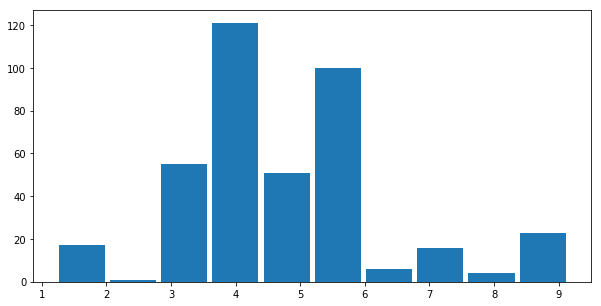

Previsão de Risco:


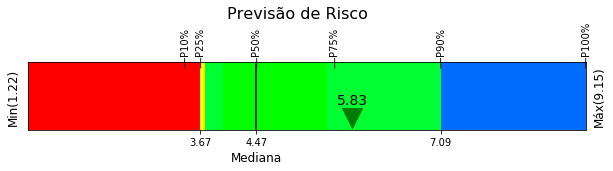




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO EM ACO 1045, COMPOSTO POR CORRENTE, COROA E PINHAO, APLICACAO TITAN 00 (44T/14T/428H x 116L)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.88
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2928.000000
média simples:          4.032622
desvio padrão:          0.789523
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020618
percentil 75%:          4.500000
valor máximo:           7.107000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.24', '90=4.55', '100=4.70'

Histograma por Decil:


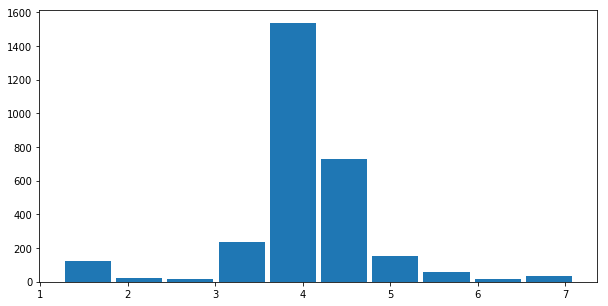

Previsão de Risco:


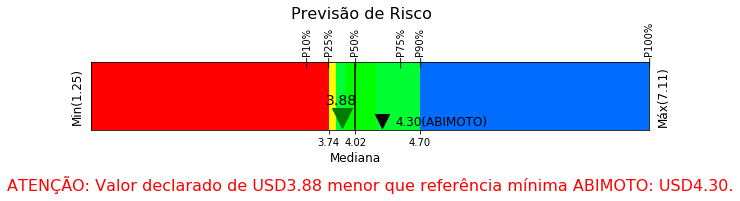




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KT0037 - KIT TRANSMISSAO PARA MOTOCICLETA CONTENDO CORRENTE, COROA E PINHAO ACO 1045, MARCA STARKE, COMPATIVEL COM XL 125 S 56Tx14T 126L 428H, EM CAIXAS COM 10 UNIDADES CADA.
Origem:    HONG KONG
Retentor:  sem retentor
Aplicação: HONDA XL XLS 125 XL125 XL125S
Valor DI:  USD 50.65
Estatísticas:
qtd de registros:    162.000000
média simples:         5.772851
desvio padrão:         1.583225
valor mínimo:          2.177000
percentil 25%:         4.694925
percentil 50%:         5.028500
percentil 75%:         7.368800
valor máximo:          9.129007

Percentis:
  '10=2.18', '20=4.35', '25=4.69', '30=4.61', '40=4.74', '50=5.00'
  '60=5.03', '70=5.51', '75=7.37', '80=7.15', '90=7.44', '100=7.87'

Histograma por Decil:


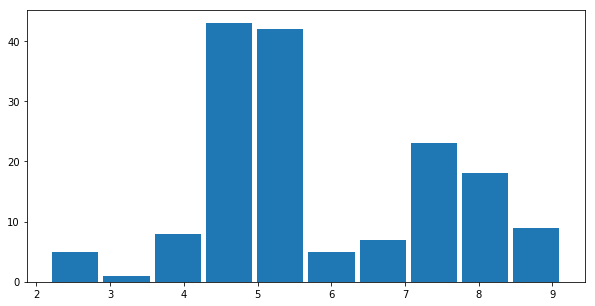

Previsão de Risco:


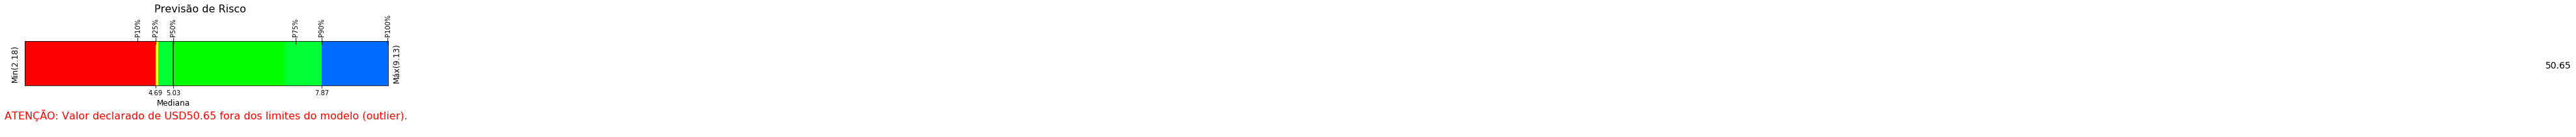




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT TRANSMISSÃO PARA MOTOCICLETA COM RETENTOR COMPOSTO POR CORRENTE, COROA E PINHÃO, MARCA KING, MODELO: CBX 250 TWISTER 520HOX106L,37T/13T
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 6.77
Tabela de Referência ABIMOTO
Valor:      USD 9.30

Estatísticas:
qtd de registros:    65.000000
média simples:        8.887886
desvio padrão:        3.268162
valor mínimo:         4.190500
percentil 25%:        5.388701
percentil 50%:        9.029000
percentil 75%:       11.429296
valor máximo:        17.483000

Percentis:
  '10=4.19', '20=4.65', '25=5.39', '30=5.15', '40=5.85', '50=9.03'
  '60=9.03', '70=10.01', '75=11.43', '80=11.06', '90=11.70', '100=12.71'

Histograma por Decil:


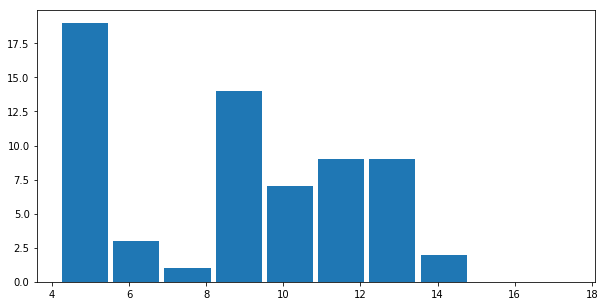

Previsão de Risco:


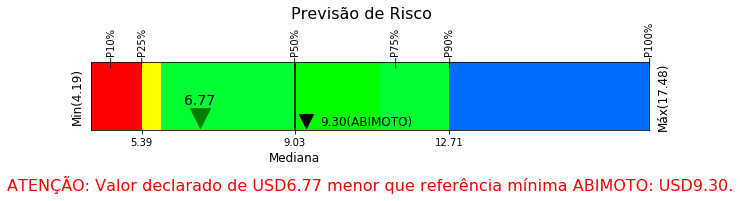




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE, COROA E PINHAO DOURADA C/ RETENTOR PARA MOTO, ITEM 428H118/14D/43D/SC-8432/SP-8143, MODELO CG125 FAN/CSK/KS 13/17
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 5.05
Estatísticas:
qtd de registros:    37.000000
média simples:        6.003732
desvio padrão:        2.263672
valor mínimo:         3.493500
percentil 25%:        3.955300
percentil 50%:        5.340602
percentil 75%:        8.446146
valor máximo:        10.210739

Percentis:
  '10=3.49', '20=3.55', '25=3.96', '30=3.68', '40=4.06', '50=4.50'
  '60=5.34', '70=6.31', '75=8.45', '80=6.91', '90=8.55', '100=9.20'

Histograma por Decil:


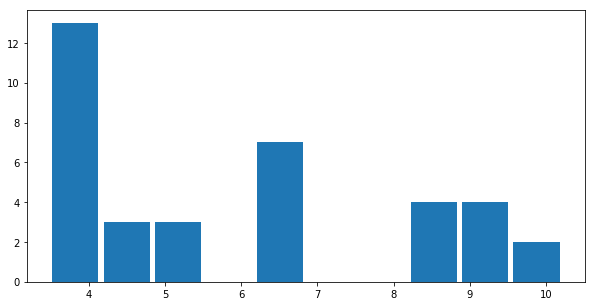

Previsão de Risco:


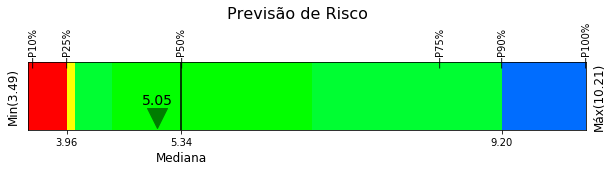




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO POR: CORRENTE, COROA E PINHAO, 1045 - 37D X 13D 520H X 106L STD, CBX 250 TWISTER ATE 2014. 001-P21B-00700F CBX 250 TWISTER ATE 2014 001-P21B-00700F
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 6.50
Tabela de Referência ABIMOTO
Valor:      USD 6.25

Estatísticas:
qtd de registros:    566.000000
média simples:         7.688954
desvio padrão:         2.992272
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.86', '25=5.81', '30=5.53', '40=5.96', '50=6.81'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.76', '100=12.70'

Histograma por Decil:


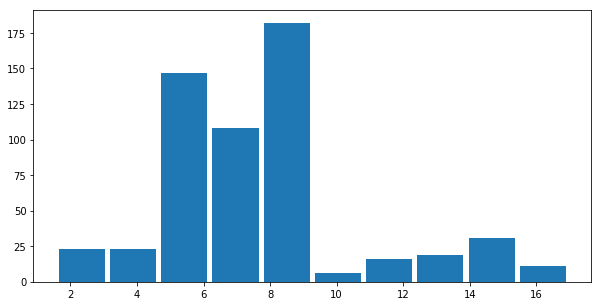

Previsão de Risco:


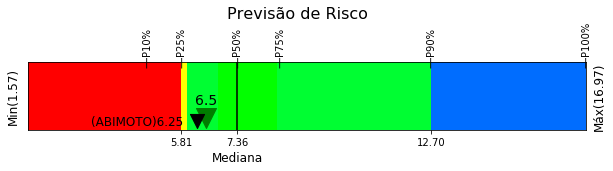




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P MOTOCICLETA MOD.: CRYPTON 105; CONTENDO COROA 37Z ; PINHAO 15Z E CORRENTE DE TRANSMISSAO 428H X 98L MARCA: EVOL 358050 358050
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUNDOWN WEB EVO
Valor DI:  USD 2.97
Estatísticas:
qtd de registros:    96.000000
média simples:        3.926770
desvio padrão:        1.092323
valor mínimo:         2.713198
percentil 25%:        3.047500
percentil 50%:        3.550000
percentil 75%:        4.540000
valor máximo:         6.130000

Percentis:
  '10=2.71', '20=2.98', '25=3.05', '30=2.99', '40=3.10', '50=3.21'
  '60=3.55', '70=3.67', '75=4.54', '80=4.10', '90=5.73', '100=5.78'

Histograma por Decil:


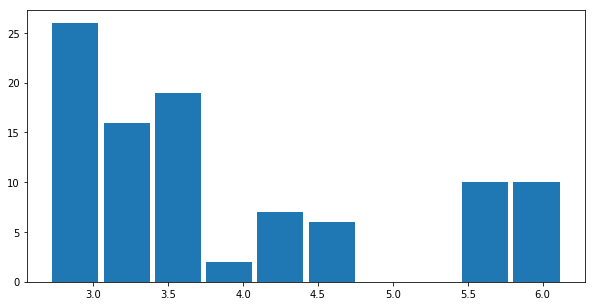

Previsão de Risco:


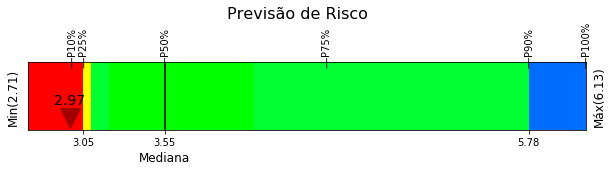




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 71877 KIT BIZ 125 (05-17) 34Z X 14Z WITH CHAIN 428H X 106L - TITANIUM (1045) -- KIT TRANSMISSAO PARA MOTOCICLETA (COROA, PINHAO E CORRENTE). ORIGEM E PROCEDENCIA: CHINA. EMBALAGEM: CAIXA DE PAPELAO.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 4.09
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1385.000000
média simples:          3.646748
desvio padrão:          0.798591
valor mínimo:           1.051026
percentil 25%:          3.270000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.05', '20=3.00', '25=3.27', '30=3.21', '40=3.33', '50=3.55'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


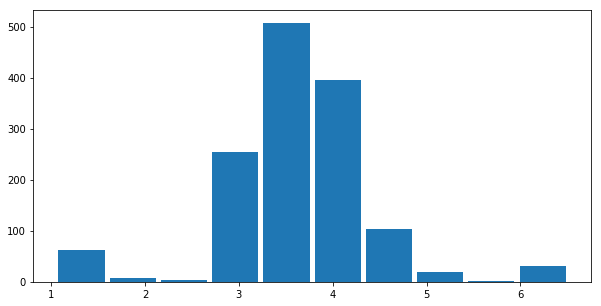

Previsão de Risco:


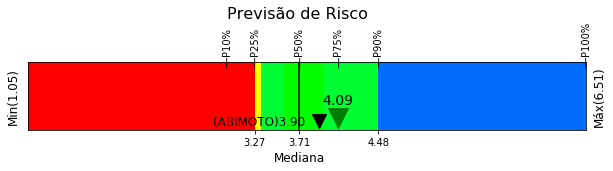




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 881582 - KIT DE TRANSMISSAO, COMPOSTO DE CORRENTE, COROA E PINHAO, UTILIZADO NAS MOTOS BIZ 125 1045 - MARCA KMC GOLD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.23
Tabela de Referência ABIMOTO
Valor:      USD 3.90

Estatísticas:
qtd de registros:    1385.000000
média simples:          3.646748
desvio padrão:          0.798591
valor mínimo:           1.051026
percentil 25%:          3.270000
percentil 50%:          3.713600
percentil 75%:          4.090000
valor máximo:           6.511000

Percentis:
  '10=1.05', '20=3.00', '25=3.27', '30=3.21', '40=3.33', '50=3.55'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'

Histograma por Decil:


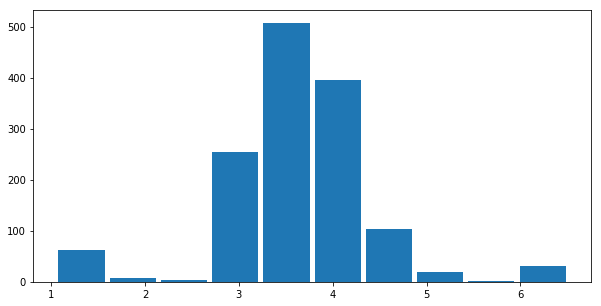

Previsão de Risco:


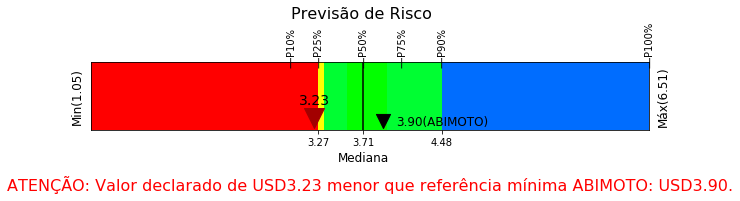




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 FAN (14-16)/ CG 125 CARGO (14-16)/ CG 125i FAN (16-18)/ CG 125i CARGO (16-18),COMPOSTO DE CORRENTE 428 X SM118 + COROA S40282 43Z + PINHAO 25104 14Z (CERTIFICADO NR. BR315120
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 3.99
Estatísticas:
qtd de registros:    1087.000000
média simples:          4.030933
desvio padrão:          0.660613
valor mínimo:           1.413541
percentil 25%:          3.800000
percentil 50%:          4.000000
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.55', '25=3.80', '30=3.70', '40=3.89', '50=3.97'
  '60=4.00', '70=4.10', '75=4.50', '80=4.28', '90=4.53', '100=4.70'

Histograma por Decil:


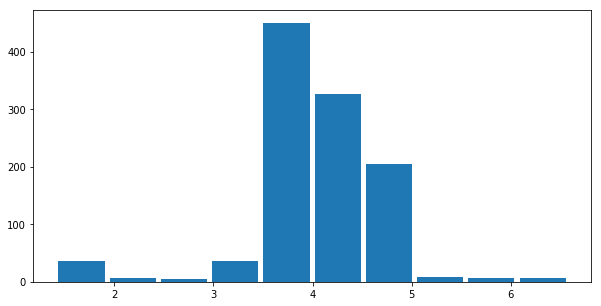

Previsão de Risco:


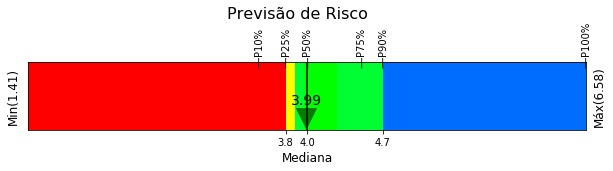




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10530037 IN - KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: NXR150BROS 09 17D/49D 428HX128L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 4.87
Estatísticas:
qtd de registros:    1896.000000
média simples:          5.479750
desvio padrão:          1.863378
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.322000

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.69', '90=6.13', '100=8.58'

Histograma por Decil:


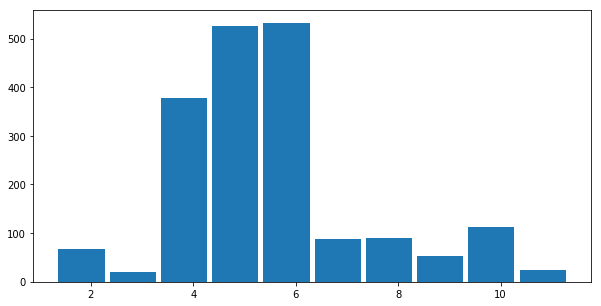

Previsão de Risco:


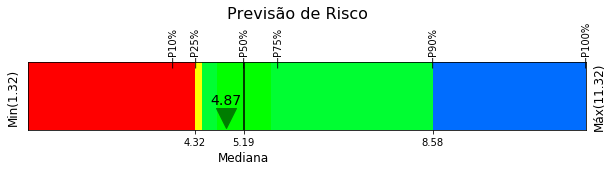




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO, MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 160 TITAN (16-19)/ CG 160 FAN (16-19) / CG 160 START (16-19)/ CG 160 CARGO (16-19), COMPOSTO DE CORRENTE 428 X SM118 + COROA S40307 44Z + PINHAO 25111 15Z (CERTIFICADO NR.BR315120
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.23
Tabela de Referência ABIMOTO
Valor:      USD 4.30

Estatísticas:
qtd de registros:    2928.000000
média simples:          4.032622
desvio padrão:          0.789523
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020618
percentil 75%:          4.500000
valor máximo:           7.107000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.24', '90=4.55', '100=4.70'

Histograma por Decil:


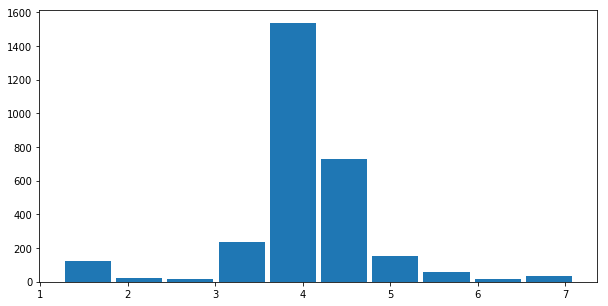

Previsão de Risco:


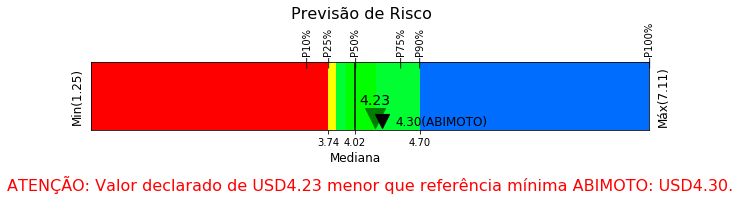




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 81588 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO PARA MOTOCICLETA CB300 10/14, MARCA KMC PRO.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CB 300R 300 CB300
Valor DI:  USD 8.17
Estatísticas:
qtd de registros:    391.000000
média simples:         8.350675
desvio padrão:         3.300826
valor mínimo:          1.574895
percentil 25%:         5.910000
percentil 50%:         8.251965
percentil 75%:         9.517640
valor máximo:         17.649038

Percentis:
  '10=1.57', '20=4.95', '25=5.91', '30=5.69', '40=6.35', '50=7.50'
  '60=8.25', '70=8.83', '75=9.52', '80=9.13', '90=9.82', '100=14.65'

Histograma por Decil:


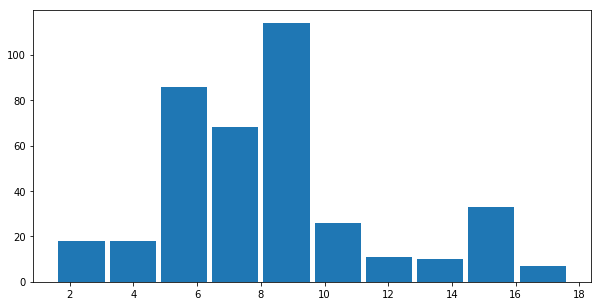

Previsão de Risco:


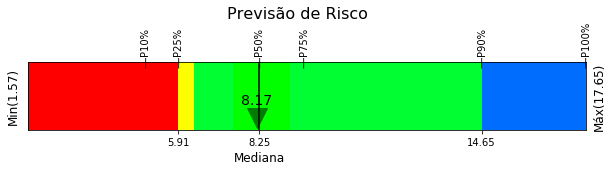

In [17]:
riscoValor(dfimp.iloc[1:])